In [2]:
import plotting_functions
import pandas as pd
import numpy as np

# Exploratory Analysis of Real Commodities Data

## Currency Basket

We choose the returns of three currencies which are heavily linked to the performance of commodities marketsin order to create a market benchmark against which to compare the performance of each commodity. To this end, we consider the average of the returns of the Canadian Dollar (CAD), Australian Dollar (AUD), and the Mexican Peso when paired with the US Dollar (USD). The resulting augmented "commodities currency basket" series is analysed in this section.

In [118]:
# Create list of currency names
currency_list = ['CME Australian Dollar AUD',
                 'CME Mexican Peso',
                 'CME Canadian Dollar CAD']

# Initialise empty dataframes with full indexing
currency_dict = {currency:  pd.DataFrame([], index = pd.bdate_range(start = '1/1/1980', end = '7/31/2020')) for currency in currency_list}

# Loop through each currency and load the data into the waiting dataframne
for currency in currency_list:
    
    current_df = pd.read_csv('Data/Continuous Futures Series/{}.csv'.format(currency), index_col = 0, skiprows = 0, skipfooter = 1, header = 1, engine = 'python')
    current_df.index = pd.to_datetime(current_df.index)
    
    currency_dict[currency] = currency_dict[currency].join(current_df)

In [119]:
from plotting_functions import series_plot

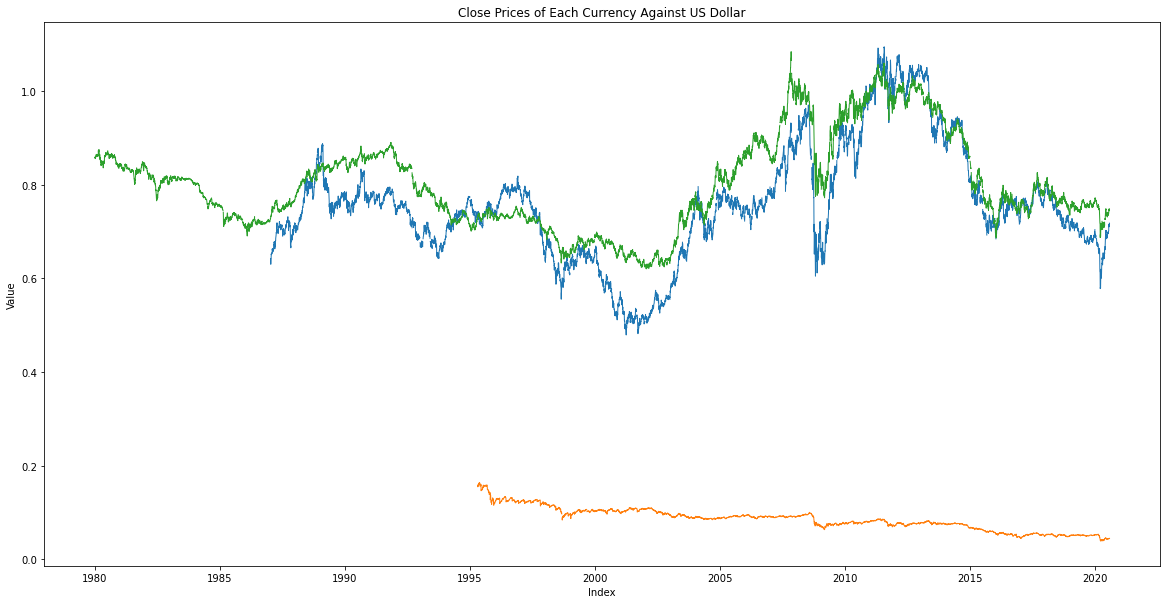

In [120]:
# Create empty dataframe of currency close prices to be filled in
currency_close_df = pd.DataFrame([], index = currency_dict['CME Canadian Dollar CAD'].index)

# Loop through each currency dataframe and pull its close price data
for currency in currency_list:
    
    currency_close_df[currency] = currency_dict[currency]['Close']
    
series_plot(currency_close_df,'Close Prices of Each Currency Against US Dollar')

While the CAD and AUD have data available back to 1980, the Peso as it is currently traded ws introduced in January 1996. As such, its series only has data available beginning near to this date. This will not be an issue, as 24 years of available daily data will be more than suitable for our purposes and we will see that our useable data range will be limited further still by similar constraints on the commodities returns data.

### Simple Average of Currencies

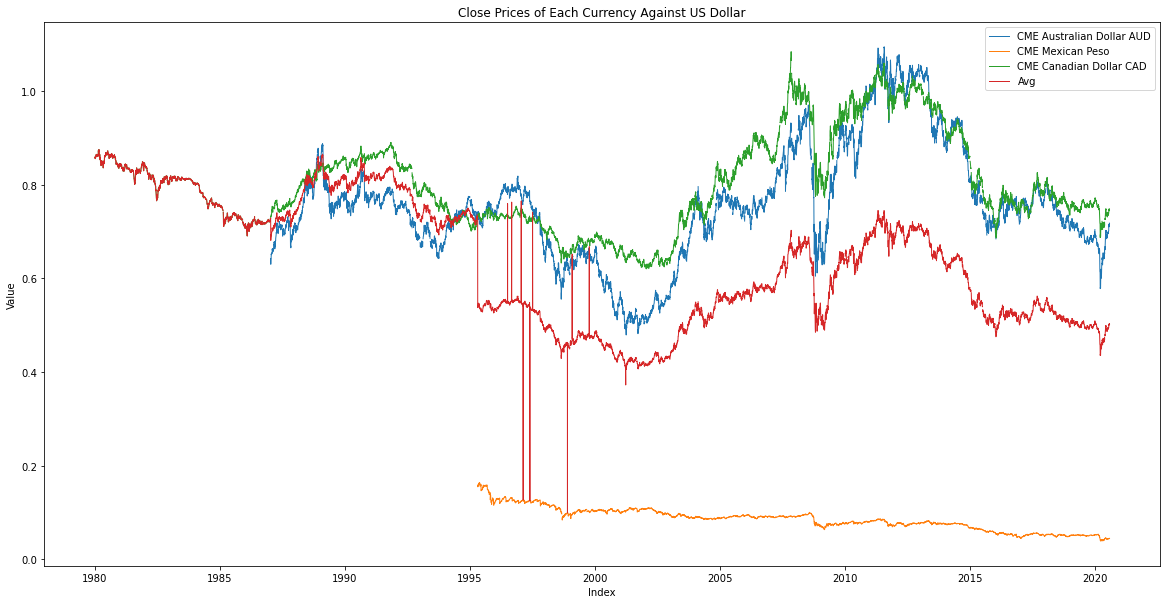

In [121]:
currency_close_df_copy = currency_close_df.copy()
currency_close_df_copy['Avg'] = currency_close_df.copy().mean(axis=1)

series_plot(currency_close_df_copy,'Close Prices of Each Currency Against US Dollar',legend=True)

The sharp spikes in the plotted data are a result of gaps in either the North American or Australian currencies. A sharp spike up is a result of missing data in the AUD, while a sharp spike down is caused by missing data in CAD and the Peso series. This is confirmed by the following plot, which is the same as the plot above but with missing data filled forwards.

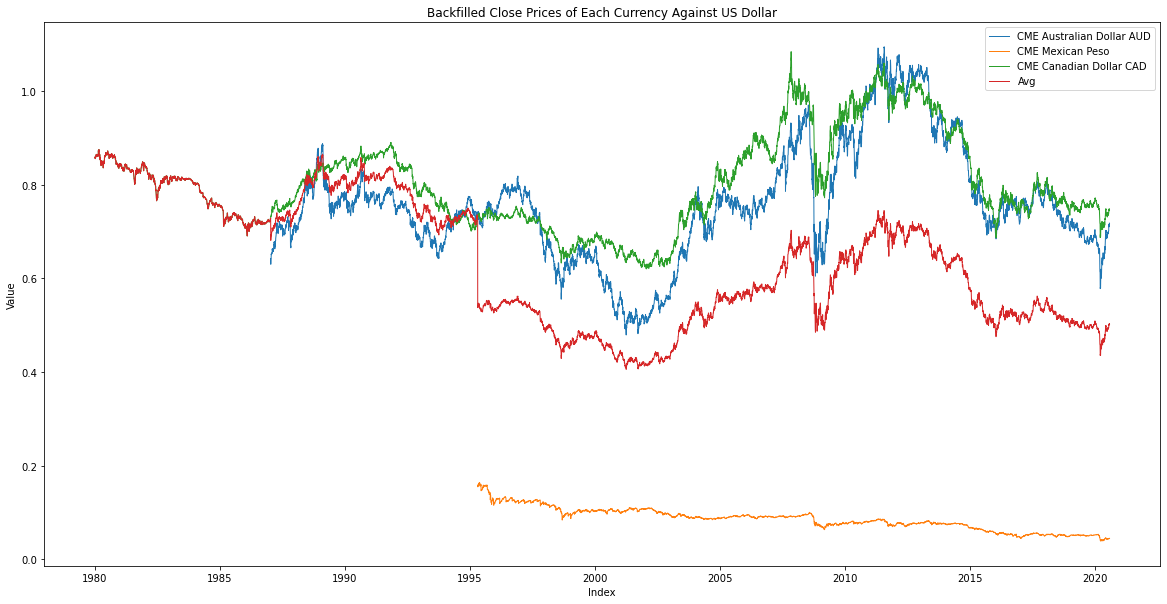

In [122]:
currency_close_df = currency_close_df.fillna(method='ffill')
currency_close_df['Avg'] = currency_close_df.mean(axis=1)

series_plot(currency_close_df,'Backfilled Close Prices of Each Currency Against US Dollar', legend=True)

We will choose not to backfill any missing dates, as this will be equivalent to having information about price data ahead of time. Instead we will fill empty data with the last known price point. As this is not possible for series that haven't yet registered any data, we truncate all currency data to the beginning date of the AUD.

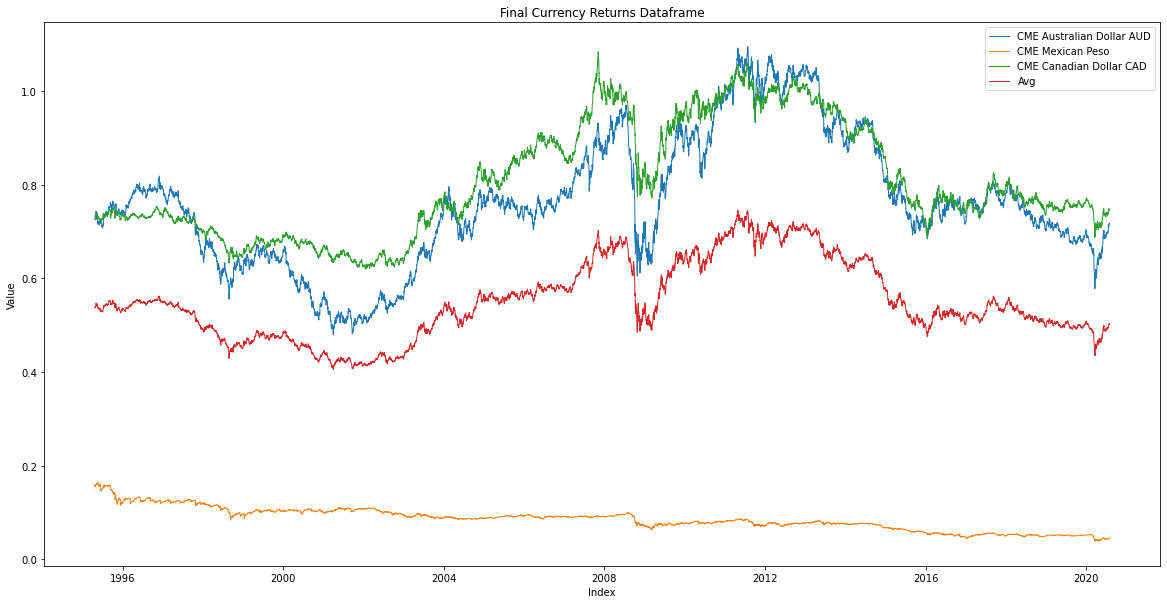

In [123]:
# Truncating currency data frame to first AUD date
mask = currency_close_df['CME Mexican Peso'].isnull()

currency_close_df = currency_close_df.loc[np.logical_not(mask)]
series_plot(currency_close_df, 'Final Currency Returns Dataframe', legend=True)

This leaves us with a final dataframe filled with returns data for each of our three currencies and their simple average. Next, we check that these returns are distributed appropriately.

### Distribution of Currencies Returns

Many desirable results necessitate the assumption that returns data is approximately normally distributed. Here we aim to validate that claim for our data. First, we constuct a series for each of our currencies which is mean-zero (by taking two day returns) and standardised by a rolling estimate of its standard deviation. Empircally we can show that a longer rolling period overestimates the variance of the returns and a shorter window underestimates it. This may be because the window size begins to take into account data from a distribution too different from the observation on the current day, a theme we will revisit often during this project. This also suggests that the data is not strictly stationary, as the observations do not have constant variance.

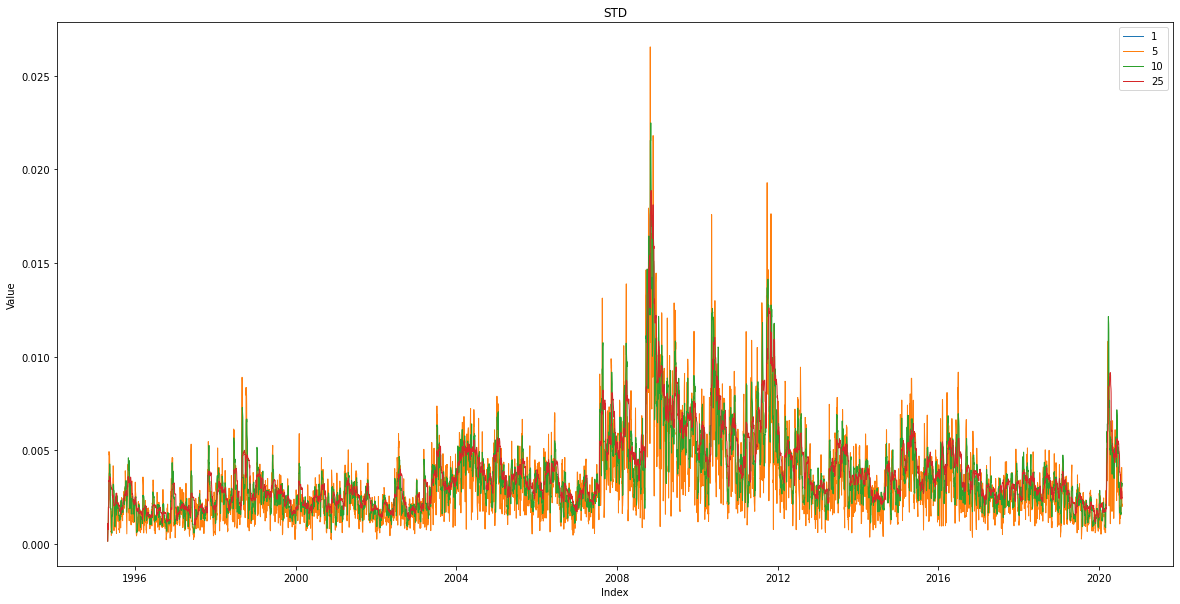

In [124]:
# Check series of standard deviation estimates for different rolling windows
std_plot = pd.DataFrame([], index=currency_close_df.index)
for window_size in [1,5,10,25]:
    std_plot[window_size] = currency_close_df['Avg'].diff(periods=2).rolling(window_size,min_periods=1).std()
series_plot(std_plot,'STD',legend=True)

We choose a rolling window of 12 days as this yields a distribution closest to a standard normal. This corresponds to around 2 business weeks.

In [145]:
# Normalised return dataframe
norm_currency_returns = pd.DataFrame([]).reindex_like(currency_close_df)

# Fill datafrane
for currency in currency_close_df:
    
    currency_std_series = currency_close_df[currency].rolling(12, min_periods = 1).std()
    
    norm_currency_returns[currency] = currency_close_df[currency].diff(periods=2) / currency_std_series

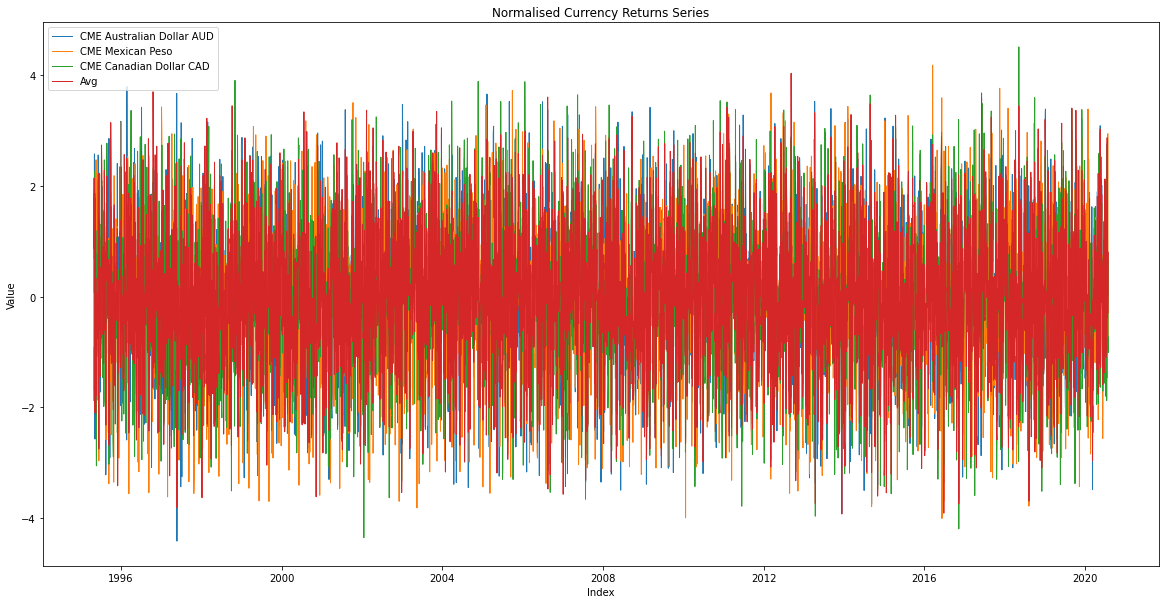

In [146]:
series_plot(norm_currency_returns,'Normalised Currency Returns Series', legend=True)

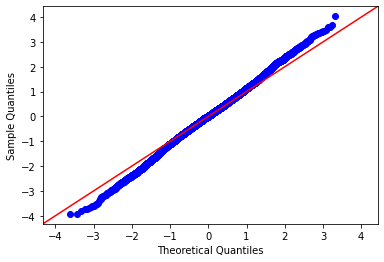

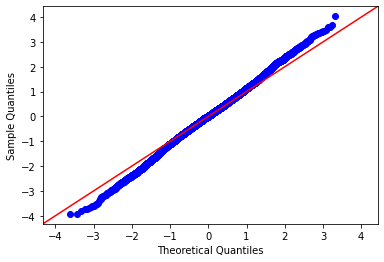

In [147]:
from statsmodels.graphics.gofplots import qqplot
qqplot(norm_currency_returns['Avg'], line="45")

With the choice of rolling estimate window size as outlined above, the QQ plots of the sample distribution indicate that the returns are approximately standard normally distributed. This is supported by the below Kernal Density Estimation of the currencies' average sample distribution.

Text(0.5, 1.0, 'Kernel Density Estimate of cStandardised Currency Returns')

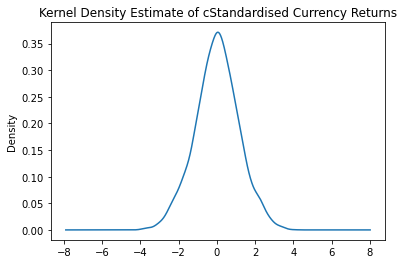

In [220]:
norm_currency_returns['Avg'].plot.kde()
plt.title('Kernel Density Estimate of cStandardised Currency Returns')

### AutoCorrelation Plots


Now we check the autocorrelation function of the currencies' simple average. As it is the mean of three series with zero ACF, we expect this too to be zero.

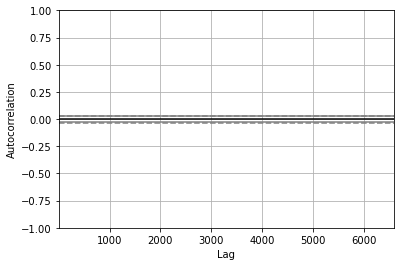

In [129]:
pd.plotting.autocorrelation_plot(norm_currency_returns['Avg'])

The simple average of the currencies has near zero autocorrelation at all lags. This validates our choice to not include auto-correlation structure to the currency composite.

## Commodities

We have access to the historical price data of the futures contracts of around 30 globally traded commodities. Whilst each series ends in July 2020, not all commodities have complete series, and not all commodities' series begin at the same date. Here we plot each series to gain a better understanding on the shape of our data.

In [130]:
# Create list of currency names
commodity_list = pd.read_csv('Data/Commodities_List_Updated.csv')['NAME']

# Initialise empty dataframes with full indexing
commodity_dict = {commodity:  pd.DataFrame([], index = pd.bdate_range(start = '1/1/1980', end = '7/31/2020')) for commodity in commodity_list}

# Loop through each currency and load the data into the waiting dataframne
for commodity in commodity_list:
    
    current_df = pd.read_csv('Data/Continuous Futures Series/{}.csv'.format(commodity), index_col = 0, skiprows = 0, skipfooter = 1, header = 1, engine = 'python')
    current_df.index = pd.to_datetime(current_df.index)
    
    commodity_dict[commodity] = commodity_dict[commodity].join(current_df)

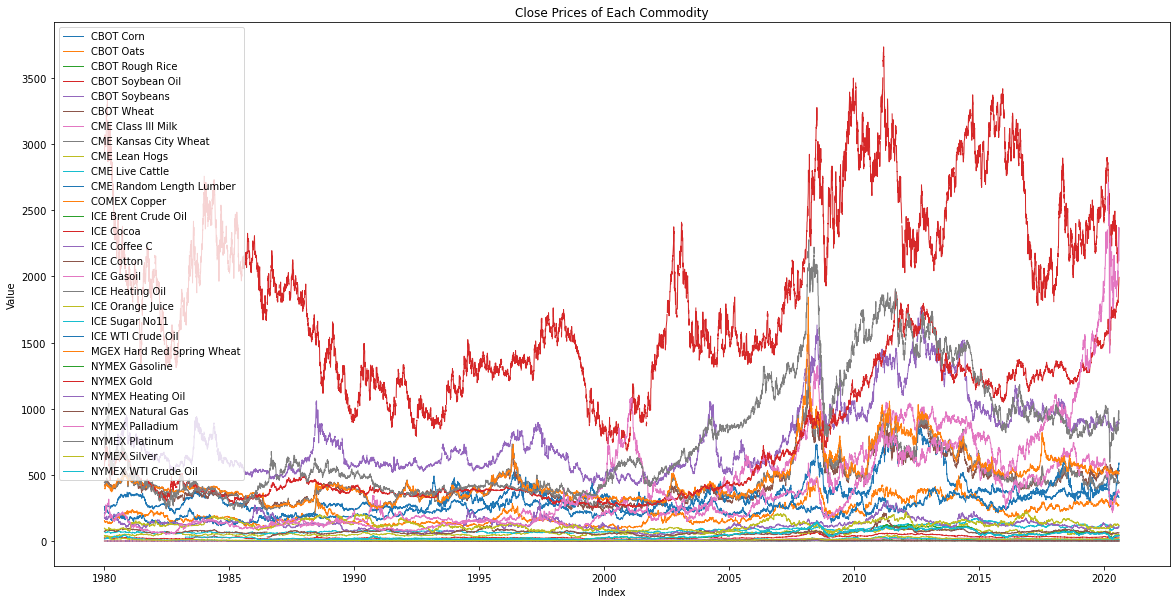

In [131]:
# Create empty dataframe of currency close prices to be filled in
commodity_close_df = pd.DataFrame([], index = commodity_dict['CBOT Corn'].index)

# Loop through each currency dataframe and pull its close price data
for commodity in commodity_list:
    
    commodity_close_df[commodity] = commodity_dict[commodity]['Close']
    
series_plot(commodity_close_df,'Close Prices of Each Commodity',legend=True)

To be consistent with our currencies data series, we trim these series to begin at the same date. As we will not use all of the commodities series in the same analyses, we do not trim them to their minimum index yet.

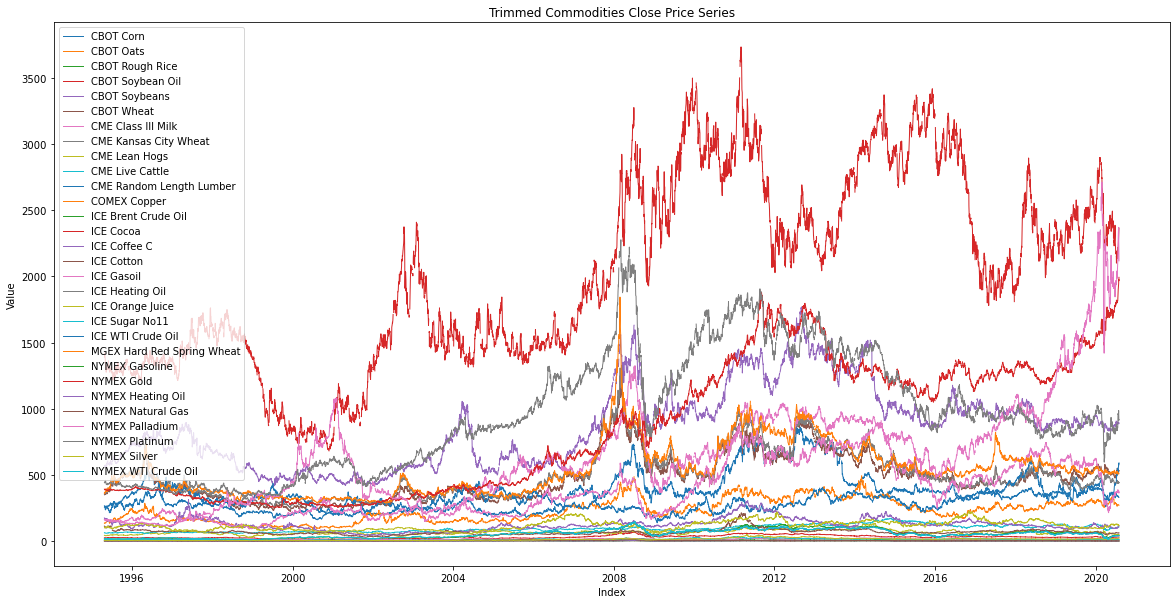

In [132]:
commodity_close_df = commodity_close_df.loc[currency_close_df['Avg'].index]
series_plot(commodity_close_df,'Trimmed Commodities Close Price Series', legend=True)

### Distribution of Commodity Returns

Here we evaluate the distribution of the returns data in the same way that we did for the currencies series. First, we constuct a series for each of our commodities which we check is mean-zero (by taking two day returns) and standardised by a rolling estimate of its standard deviation. For consistency we will use the same window size as we did for the currencies.

In [206]:
# Here we test that the mean of our commodities returns is 0 using a standard student's t-test
import scipy.stats
# Find estimates of mean returns
mus = commodity_close_df.diff(periods=2).mean(axis=0)

# Find an estimate of standard deviation for each return
sigmas = commodity_close_df.diff(periods=2).std()

# Find number of observations of each return
Ns = commodity_close_df.diff(periods=2).count()

# Construct test quantities under 0-mean assumption
test_quants = -abs(mus / (sigmas / np.sqrt(Ns)))

# Find P-values for each test quantity
p_vals = scipy.stats.norm(0, 1).cdf(test_quants)

for i, p_val in enumerate(p_vals):
    print('{}: {:.3f}'.format(commodity_close_df.columns[i], p_val))

CBOT Corn: 0.437
CBOT Oats: 0.261
CBOT Rough Rice: 0.377
CBOT Soybean Oil: 0.473
CBOT Soybeans: 0.405
CBOT Wheat: 0.313
CME Class III Milk: 0.183
CME Kansas City Wheat: 0.388
CME Lean Hogs: 0.422
CME Live Cattle: 0.397
CME Random Length Lumber: 0.105
COMEX Copper: 0.286
ICE Brent Crude Oil: 0.485
ICE Cocoa: 0.279
ICE Coffee C: 0.317
ICE Cotton: 0.462
ICE Gasoil: 0.425
ICE Heating Oil: 0.268
ICE Orange Juice: 0.328
ICE Sugar No11: 0.382
ICE WTI Crude Oil: 0.257
MGEX Hard Red Spring Wheat: 0.366
NYMEX Gasoline: 0.457
NYMEX Gold: 0.027
NYMEX Heating Oil: 0.249
NYMEX Natural Gas: 0.293
NYMEX Palladium: 0.112
NYMEX Platinum: 0.476
NYMEX Silver: 0.344
NYMEX WTI Crude Oil: 0.476


The results of the two-sided student's t-test show that only one of the 30 commodities considered (NYMEX Gold) has a mean significantly (p-value < 0.05) non-zero. However when considering this many tests in tandem, we use Fisher's combined probability test which, under the assumption that the tests are independent, gives us a single p-value as a result. This is because the chance of reecieving an anomalous result increases with the number of tests that we perform.

In [200]:
# Applying Fisher's method
fisher_pval = -2 * sum(np.log(p_vals))
scipy.stats.chi2(df=2*len(p_vals)).cdf(fisher_pval)

0.8682182586749065

Applying Fisher's method to our problem shows that our p-values contain a very normal number of significantly high results, and so we can now be confident that each of the 30 commodities' returns can be assumed to have zero-mean.

In [163]:
# Normalised return dataframe
norm_commodity_returns = pd.DataFrame([]).reindex_like(commodity_close_df)

# Fill datafrane
for commodity in commodity_close_df:
    
    commodity_std_series = commodity_close_df[commodity].rolling(12, min_periods = 1).std()
    
    norm_commodity_returns[commodity] = commodity_close_df[commodity].diff(periods=2) / commodity_std_series

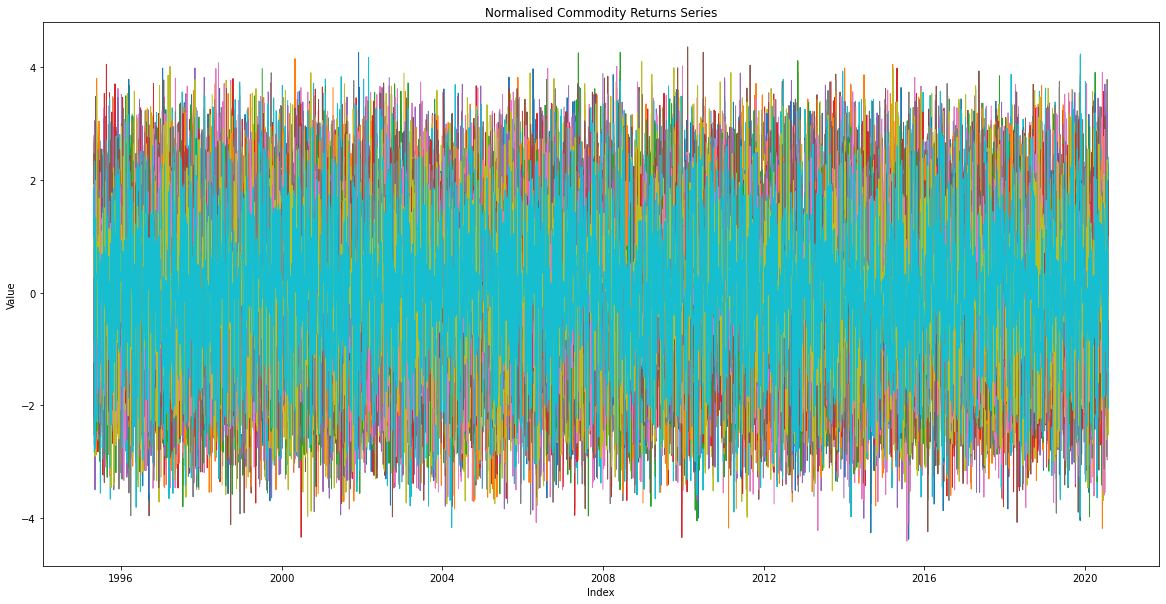

In [164]:
series_plot(norm_commodity_returns,'Normalised Commodity Returns Series')

As we are no longer interested in just a simple average, we do not have the luxury of analysing a single series. Instead, we plot the QQ-plots for the returns of each of our 30 commodities.

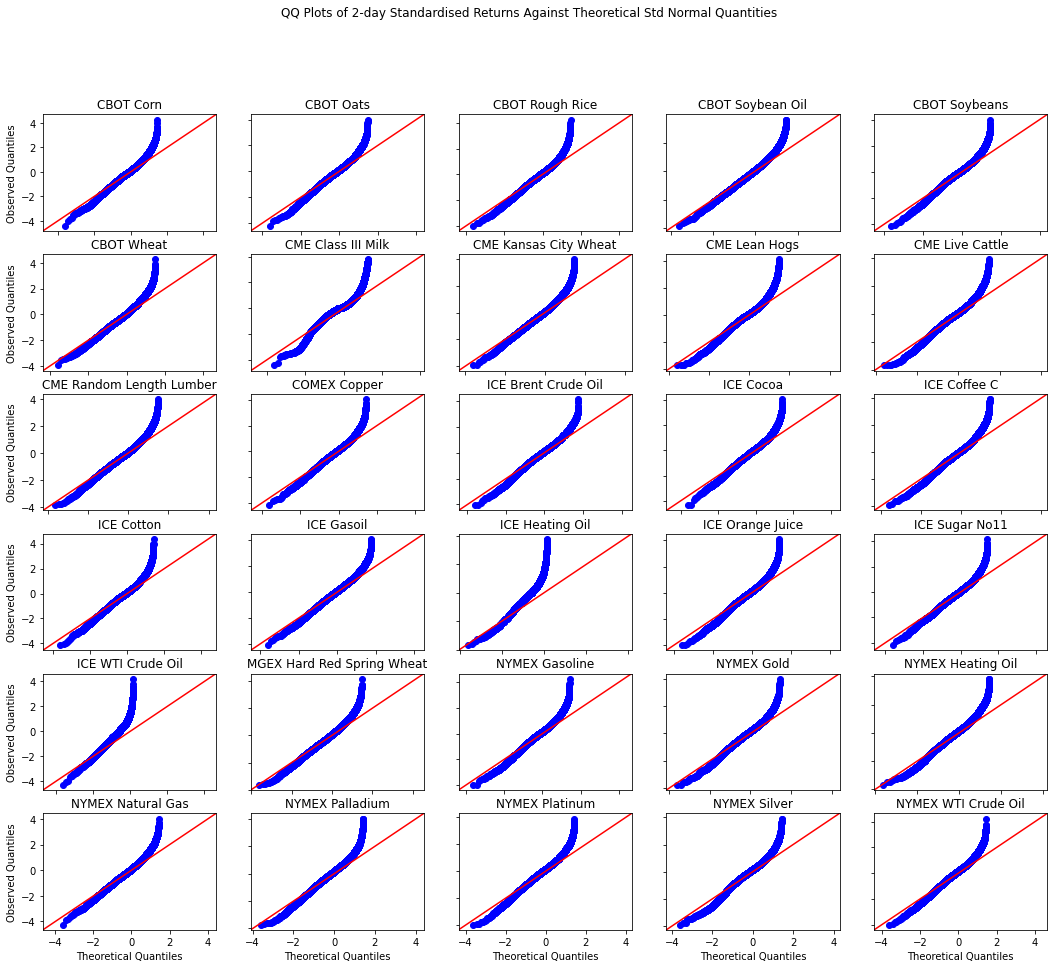

In [165]:
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
fig, axs = plt.subplots(6,5, figsize=(18,15))

fig.suptitle('QQ Plots of 2-day Standardised Returns Against Theoretical Std Normal Quantities')

for i, commodity in enumerate(norm_commodity_returns):
    
    qqplot(norm_commodity_returns[commodity], ax = fig.axes[i], line="45")

for i, ax in enumerate(axs.flat):
    ax.set(xlabel='Theoretical Quantiles', ylabel='Observed Quantiles')
    ax.set_title(commodity_list[i])
    
for ax in fig.get_axes():
    ax.label_outer()

In contrast to the distribution of the currency simple average, the standartdised additive returns of the commodities appear to have much more weight in their right tails. This may be because the price of commodities increases with a near linear drift term, however this result in positive mean return. This is one factor we must take into account when considering our brownian motion generation of commodities prices.

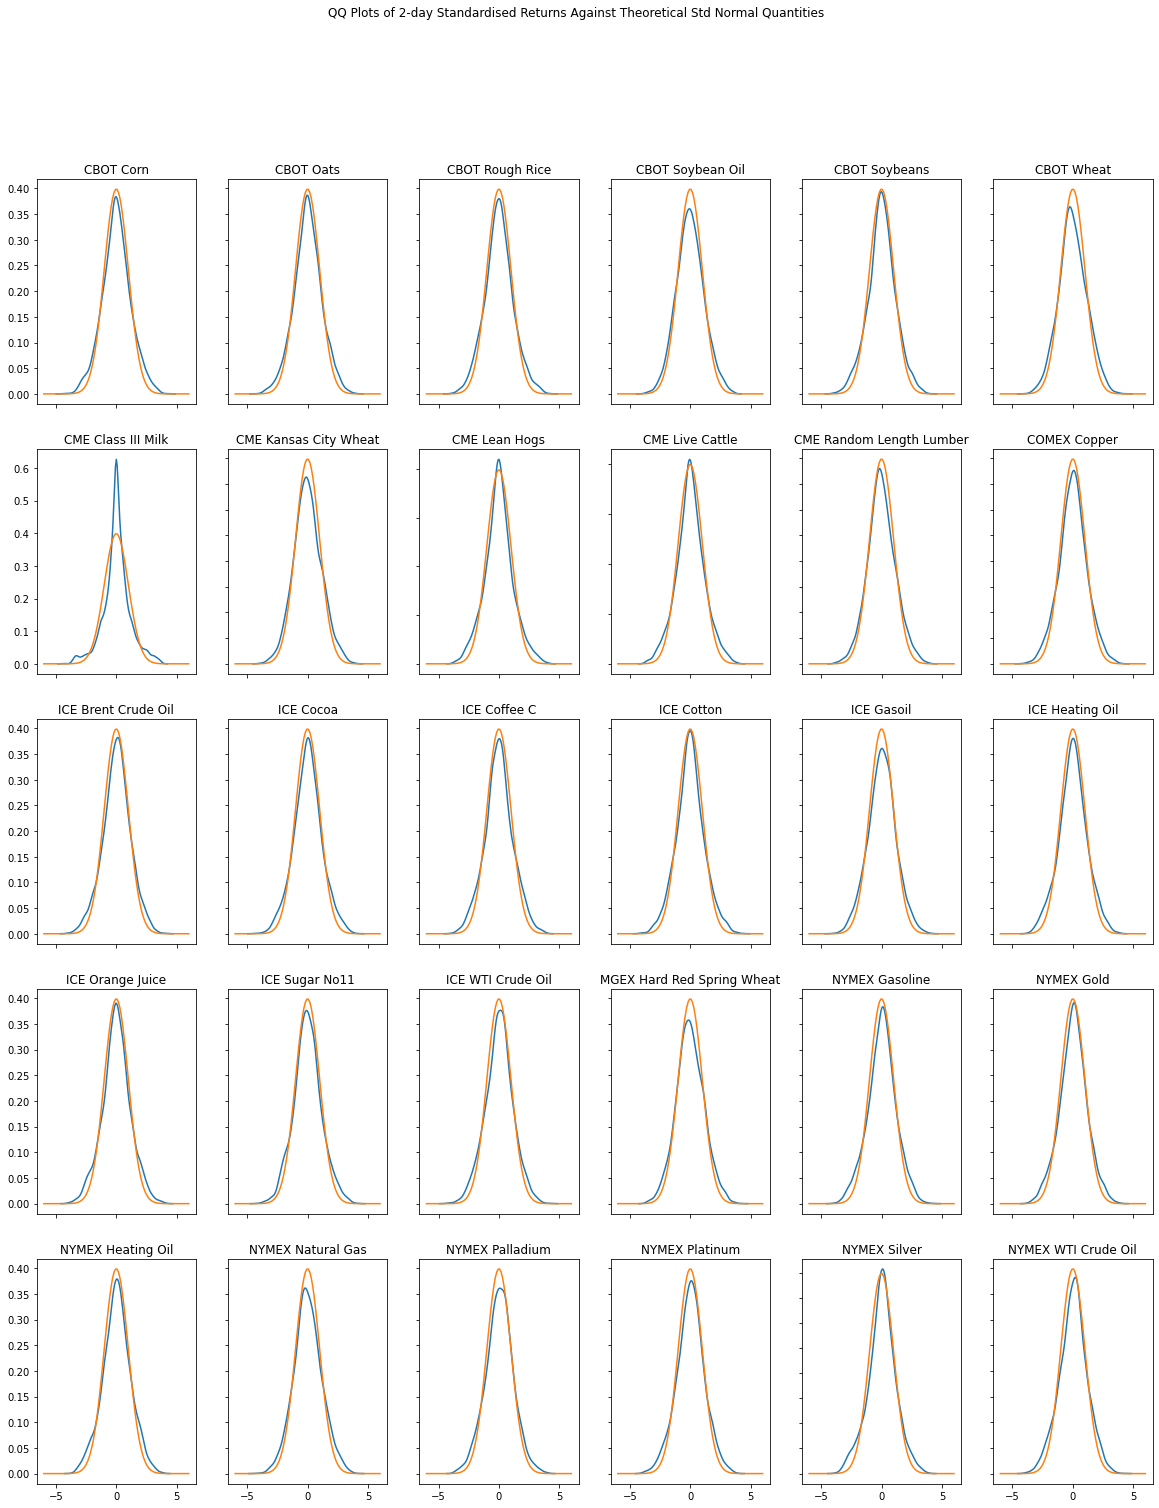

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

fig, axs = plt.subplots(5,6, figsize=(20,24))

fig.suptitle('QQ Plots of 2-day Standardised Returns Against Theoretical Std Normal Quantities')

x = np.linspace(-6, 6, 100)

for i, commodity in enumerate(norm_commodity_returns):
    sns.kdeplot(norm_commodity_returns[commodity], ax = fig.axes[i], legend=False)
    fig.axes[i].plot(x, stats.norm.pdf(x, 0, 1))
    
for i, ax in enumerate(axs.flat):
#     ax.set(xlabel='Theoretical Quantities', ylabel='Observed Quantities')
    ax.set_title(commodity_list[i])

for ax in fig.get_axes():
    ax.label_outer()

As expected from previous analyses, each commodity's returns have mean very close to zero, and slightly heavier tails than the standard normal of which they are assumed to be observations. Additionally the right tail looks to be marginally heavier than the left.

### AutoCorrelation Plots


Now we check the autocorrelation function of the currencies' simple average. As it is the mean of three series with zero ACF, we expect this too to be zero.

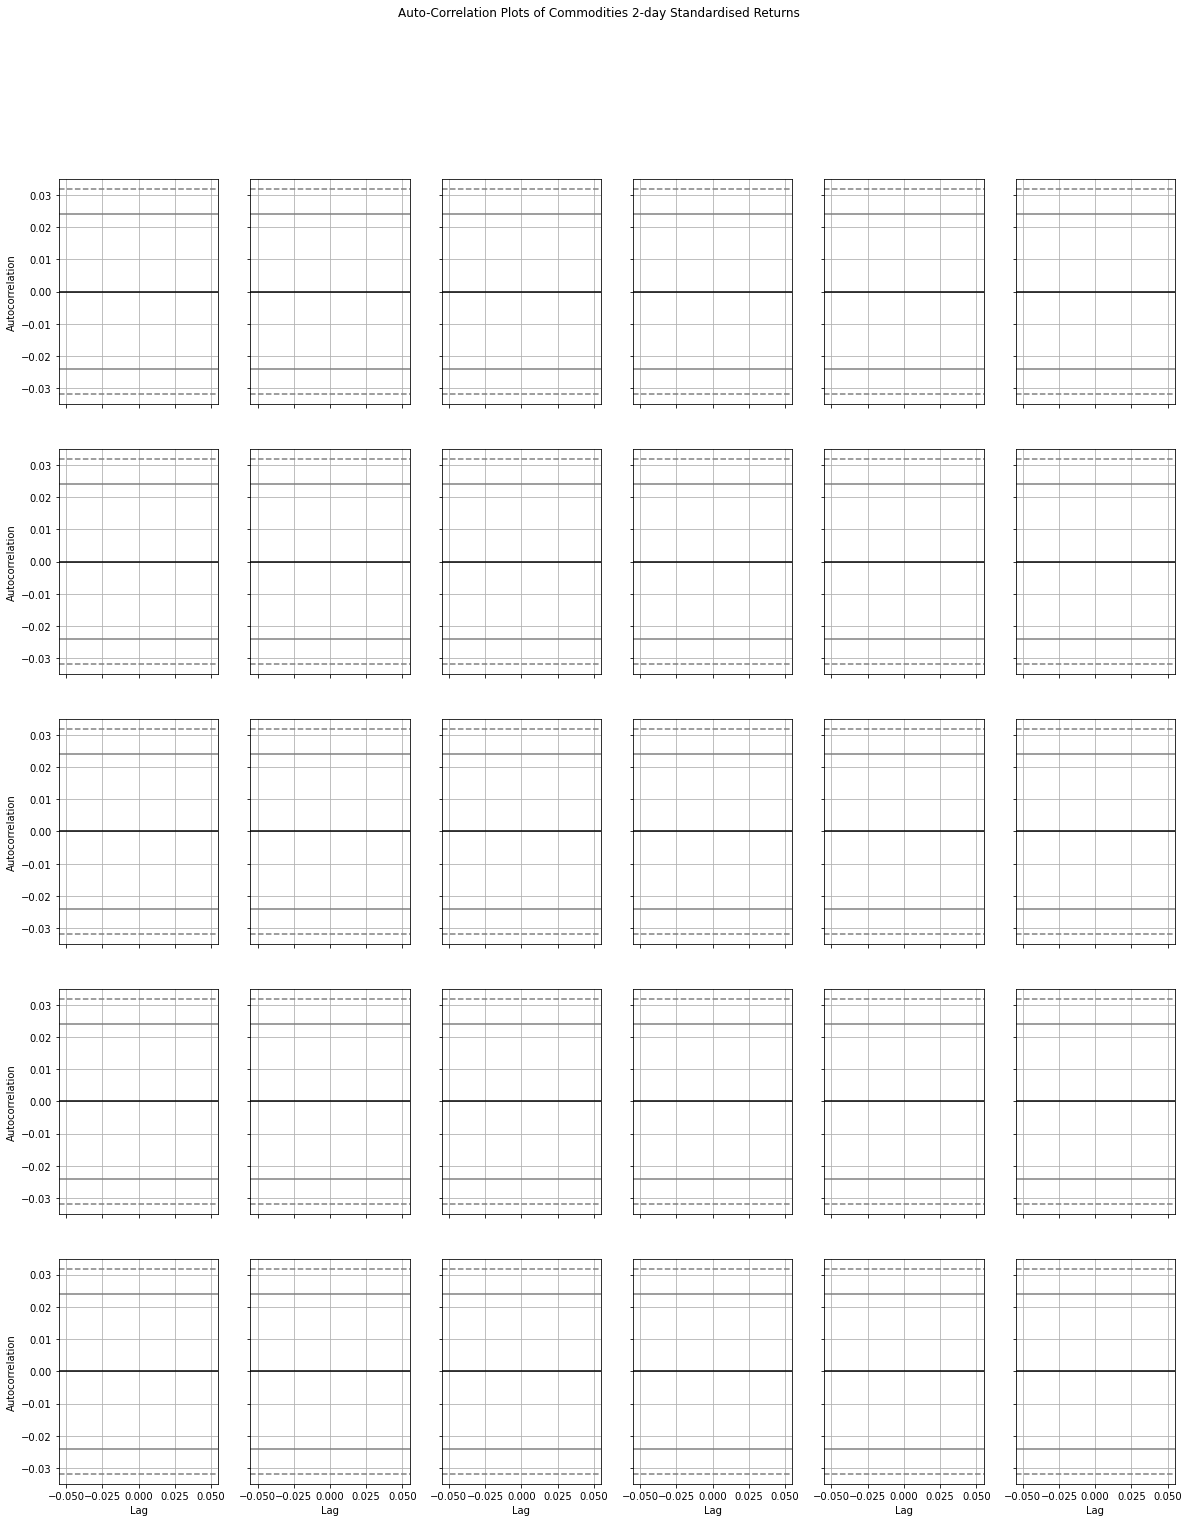

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

fig, axs = plt.subplots(5,6, figsize=(20,24))

fig.suptitle('Auto-Correlation Plots of Commodities 2-day Standardised Returns')

for i, commodity in enumerate(norm_commodity_returns):
    pd.plotting.autocorrelation_plot(norm_commodity_returns, ax = fig.axes[i])
    
# for i, ax in enumerate(axs.flat):
# #     ax.set(xlabel='Theoretical Quantities', ylabel='Observed Quantities')
#     ax.set_title(commodity_list[i])

for ax in fig.get_axes():
    ax.label_outer()

The each of the currencies has near zero autocorrelation at all lags. This validates our choice to not include auto-correlation structure to the generation of the commodities series also.

### Market Simulation

Our simulation framework simulates a structured market by first generating a series of returns for the currency composite (or market benchmark), which we will call $M(t)$, with $t \in \mathbb{N}$ denoting day $t$. The series of returns for the $i^{th}$ commodity $C_i, 
\ i=1,2,\dots,d$ are therefore given by

$$
C_i = \beta_i(t) M(t) + \epsilon_i (t)
$$

where $\beta_i(t)$ is a discrete series of coefficients some continous function $f_i(t) = \beta_i(t)$ and $\epsilon_i\sim N(0,\sigma_i)$ is some unobserved, i.i.d. noise. This looks a lot like the design matrix for a family of linear models, with the added difficulty that observations are heavily correlated (in time). Later we will analyse how best to deal with the trade off of having too many correlated observations with included too little data. It will turn out that whie our estimates can be controlled, we will routinely over-estimate our confidence in our estimates.

As the question of how best to generate the currency composite $M(t)$ has been answered above, the obvious next question of how to choose an appropriate $f_i(t)$ is answered next.

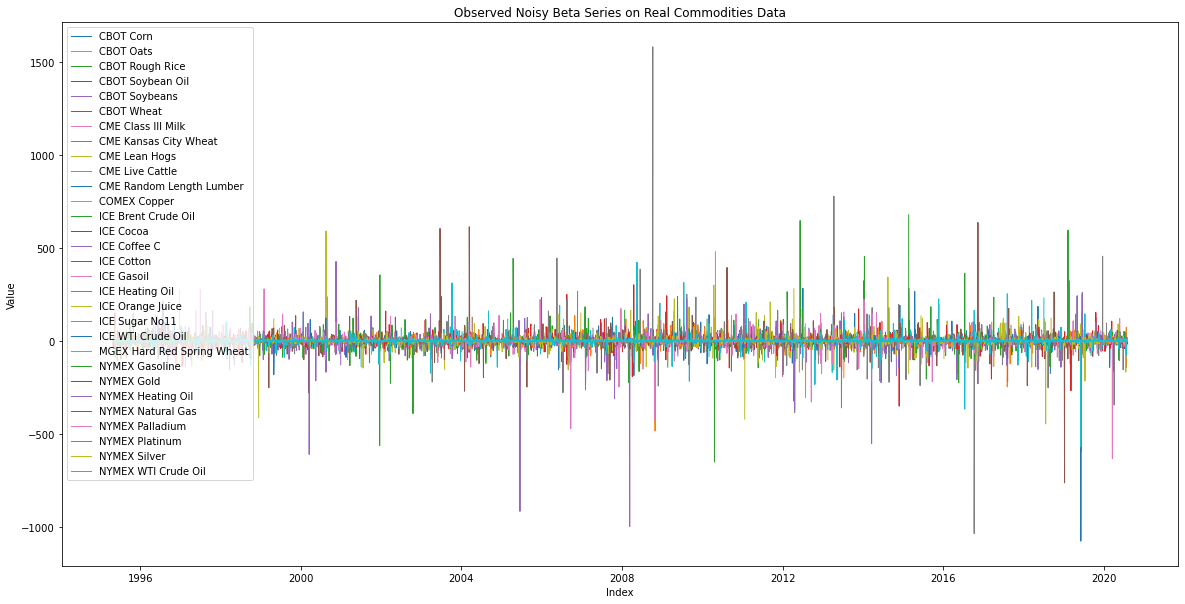

In [234]:
beta_obs_df = pd.DataFrame([], columns = norm_commodity_returns.columns).reindex_like(norm_commodity_returns)

for i, commodity in enumerate(beta_obs_df):
    beta_obs_df[commodity] = norm_currency_returns['Avg'] / norm_commodity_returns[commodity]

series_plot(beta_obs_df, 'Observed Noisy Beta Series on Real Commodities Data', legend=True)

In [271]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data


# Load image
original = pywt.data.camera()

# Wavelet transform of image, and plot approximation and details

(cA, cD) = pywt.dwt(beta_obs_df['CBOT Corn'], 'db1')
print(len(beta_obs_df['CBOT Corn']), len(cA))
      
# beta_obs_df['CBOT Corn Denoised'] = cA
# LL, (LH, HL, HH) = coeffs
# fig = plt.figure(figsize=(12, 3))

# for i, a in enumerate([LL, LH, HL, HH]):
#     ax = fig.add_subplot(1, 4, i + 1)
#     ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)


# fig.tight_layout()
# plt.show()

6594 3301


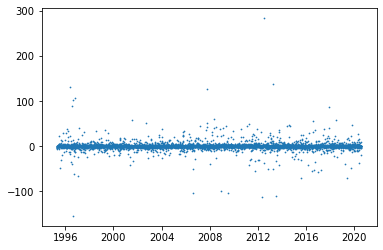

In [284]:
plt.scatter(beta_obs_df.index, beta_obs_df['CBOT Corn'], s=0.5)